# Final Project
**SEPTA On-Time Performance Prediction \
Yang Yan** \
This project intends to locate the elements that cause train delays. The goal is to build a model which takes in train line, date, time and station, and gives the predicted arrival time of the train.

Potential models include decision tree, k-nearest-neighbor, or neural network. As for feature selection, besides the given dataset, weather data will also be collected via an API as weather could be a significant factor in OTP. When giving predictions, if the selected date is within 7 days, a weather forecast would also be pulled to be considered. Otherwise, weather would be assumed clear in the model. 

This project is particularly of interest to people who commutes daily from central Philadelphia to the suburban area. The predictions could also be useful for train schedulers and dispatchers to help them understand the bottleneck of the rail network.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from joblib import dump, load

In [2]:
# Read in data
otp_df = pd.read_csv('otp.csv')

# Data Cleaning

In [3]:
def reformat_status(in_str):
    out_str = in_str.replace(' min', '')
    out_str = out_str.replace('On Time', '0')
    return int(out_str)

otp_df['delay'] = otp_df['status'].apply(reformat_status)
otp_df['origin'] = otp_df['origin'].apply(lambda x: 'origin_'+x)
otp_df['next_station'] = otp_df['next_station'].apply(lambda x: 'next_'+x)

In [4]:
# remove extreme data
otp_df = otp_df.drop(otp_df[otp_df['delay']>=999].index)
otp_df = otp_df.drop(otp_df[otp_df['date'] == '2016-04-03'].index)
otp_df = otp_df.drop(otp_df[otp_df['date'] == '2016-04-08'].index)
otp_df = otp_df.dropna()

# Exploratory Data Analysis

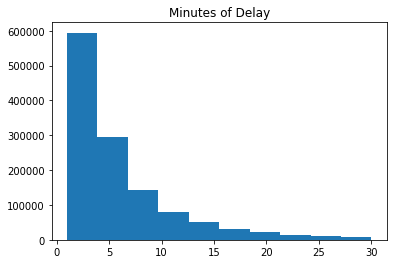

In [5]:
# plot minutes of delay histogram
plt.hist(otp_df[(otp_df['delay']<=30) & (otp_df['delay']>0)].delay)
plt.title('Minutes of Delay')
plt.show()

Clearly, this is a long tail distribution. The majority of delays are within 5 minutes, which is arguably an acceptable figure. Next, we want to see whether the day of the week affects OTP.

In [6]:
otp_df['date'] = pd.to_datetime(otp_df['date'], infer_datetime_format=True)
otp_df['timeStamp'] = pd.to_datetime(otp_df['timeStamp'], infer_datetime_format = True)
otp_df['weekday'] = otp_df['date'].apply(lambda x: x.weekday()+1)

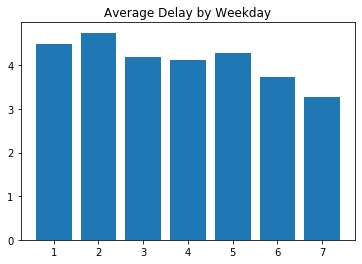

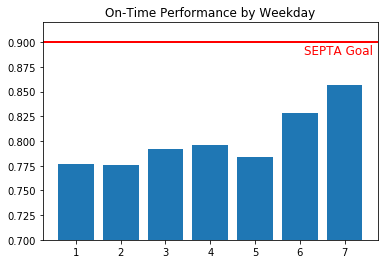

In [7]:
weekday_delay = []
weekday_otp = []
for i in range(1,8):
    weekday_delay.append(otp_df[(otp_df['delay']!=999) & (otp_df['weekday'] == i)].delay.mean())
    on_time = len(otp_df[(otp_df['delay']<=6) & (otp_df['weekday'] == i)])
    total = len(otp_df[otp_df['weekday'] == i])
    weekday_otp.append(on_time/total)
    
plt.bar(range(1,8), weekday_delay)
plt.title('Average Delay by Weekday')
plt.show()
plt.bar(range(1,8), weekday_otp)
plt.ylim([0.7,0.92])
plt.axhline(0.9, color='r', linewidth=2)
plt.text(6.1,0.888,'SEPTA Goal',fontsize=12,color='r')
plt.title('On-Time Performance by Weekday')
plt.show()

The OTP on weekends is significantly better than that on weekdays, which makes sense because there might be less trains on weekends due to low demand. In general, SEPTA has failed its goal of 90% on-time rate. (Note that SEPTA categorizes all delays within 6 minutes as on time.)

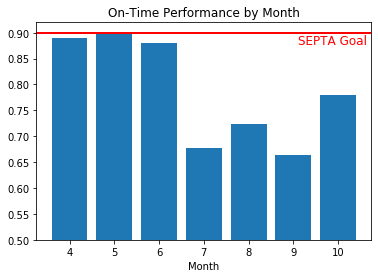

In [8]:
otp_df['month'] = otp_df['date'].apply(lambda x: x.month)
month_otp = []
for month in range(4,11):
    on_time = len(otp_df[(otp_df['delay']<=6) & (otp_df['month'] == month)])
    total = len(otp_df[otp_df['month'] == month])
    month_otp.append(on_time/total)
    
plt.bar(range(4,11), month_otp)
plt.ylim([0.5,0.92])
plt.axhline(0.9, color='r', linewidth=2)
plt.text(9.1,0.878,'SEPTA Goal',fontsize=12,color='r')
plt.title('On-Time Performance by Month')
plt.xlabel('Month')
plt.show()

The OTP reachs its goal in April, May and June; however, performance has deteriorated significantly in summer months, which is a phenomenon that is yet to explain. 

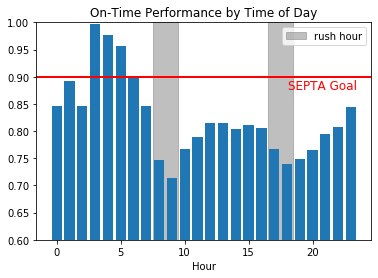

In [9]:
otp_df['hour'] = otp_df['timeStamp'].apply(lambda x: x.hour)
hour_otp = []
for hour in range(24):
    on_time = len(otp_df[(otp_df['delay']<=6) & (otp_df['hour'] == hour)])
    total = len(otp_df[otp_df['hour'] == hour])
    hour_otp.append(on_time/total)
    
plt.axvspan(7.5, 9.5, alpha=0.5, color='grey')
plt.axvspan(16.5, 18.5, alpha=0.5, color='grey', label = 'rush hour')
plt.bar(range(24), hour_otp)
plt.ylim([0.6,1])
plt.axhline(0.9, color='r', linewidth=2)
plt.text(18.1,0.878,'SEPTA Goal',fontsize=12,color='r')
plt.title('On-Time Performance by Time of Day')
plt.xlabel('Hour')
plt.legend()
plt.show()

We can see significant drops in OTP during rush hours, namely 8-9am and 5-6pm. One interesting thing is that the evening rush hour seems to last longer than the morning one. This makes sense because people have to get to work at between 8-9am, but they do not necessary have to return between 5-6pm (for example, they could have to work overtime, have dinner in city, go to the pubs, etc.)

In [10]:
otp_df['day'] = otp_df['date'].apply(lambda x: x.day)

## Import weather data
The historical weather data is retrieve from [the Franklin Institute](https://www.fi.edu/history-resources/philadelphia-weather-data). The original data format is xls, and it was cleaned using Excel before being converted to csv.

In [11]:
weather_df = pd.read_csv('Historical_Weather_Data_2016.csv').fillna(value=0)

Specfic rainfall numbers is trivial to the model. Therefore, it is converted to categorical data with three classes: clear, small rain and heavy rain. The cutoff is based on the distribution of the data. The same procedure is done to snowfall data.

In [12]:
def reformat_rain(x):
    if x == 0:
        out = 'no_rain'
    elif x<=1:
        out = 'small'
    else:
        out = 'heavy'
    return out

weather_df['rain'] = weather_df['Liquid'].apply(reformat_rain).astype(str)

def reformat_snow(x):
    if x == 0:
        out = 'no_snow'
    else:
        out = 'snow'
    return out
        
weather_df['snow'] = weather_df['Snow'].apply(reformat_snow).astype(str)

# Prediction of on-timeness
First, we use a binary classifier to identify scenarios where a train is delayed. Multiple possible models are tried, and due to  huge class imbalance, the performance measure is somewhat complicated. Accuracy, recall, specificity, and precision-recall curve are used to give a comprehensive view of the model performance.

## Feature Selection
Since we do not have a whole year's data, month and day become somewhat irrelavent. Therefore, only weekday and hour are used in terms of date/time. The direction of the train, the train origin (representative of the train line), and the current station are also used. Weather conditions (rain/snow) are also included. 

In [13]:
merged_df = otp_df.merge(weather_df, how='left', left_on=['month','day'], right_on=['Month', 'Day'])
merged_df = merged_df.drop(['month','day','Depth','status','date','timeStamp','train_id','Month','Day','Liquid','Snow'],axis=1)
merged_df.hour =  merged_df.hour.apply(lambda x: str(x)+'h')

In [14]:
merged_df.direction = merged_df.direction.astype('category')
merged_df.origin = merged_df.origin.astype('category')
merged_df.next_station = merged_df.next_station.astype('category')
merged_df.weekday = merged_df.weekday.astype('category')
merged_df.hour = merged_df.hour.astype('category')
merged_df.rain = merged_df.rain.astype('category')
merged_df.snow = merged_df.snow.astype('category')

merged_df = pd.concat([merged_df.drop('direction', axis=1), pd.get_dummies(merged_df['direction'])], axis=1)
merged_df = pd.concat([merged_df.drop('origin', axis=1), pd.get_dummies(merged_df['origin'])], axis=1)
merged_df = pd.concat([merged_df.drop('next_station', axis=1), pd.get_dummies(merged_df['next_station'])], axis=1)
merged_df = pd.concat([merged_df.drop('weekday', axis=1), pd.get_dummies(merged_df['weekday'])], axis=1)
merged_df = pd.concat([merged_df.drop('hour', axis=1), pd.get_dummies(merged_df['hour'])], axis=1)
merged_df = pd.concat([merged_df.drop('rain', axis=1), pd.get_dummies(merged_df['rain'])], axis=1)
merged_df = pd.concat([merged_df.drop('snow', axis=1), pd.get_dummies(merged_df['snow'])], axis=1)

merged_df = merged_df.drop(['Max', 'Min'], axis=1)
merged_df

,delay,N,S,origin_16th St Jct,origin_20th St,origin_30th South,origin_30th Street Station,origin_49th St,origin_60th St North,origin_9th St,...,5h,6h,7h,8h,9h,heavy,no_rain,small,no_snow,snow
0,1,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,1,0
1,1,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,1,0
2,2,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,1,0
3,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,1,0
4,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1865466,12,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,1,0
1865467,7,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,1,0
1865468,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,1,0
1865469,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,1,0


In [15]:
def create_label(x):
    if x<= 6:
        return 0
    else:
        return 1

merged_df['label'] = merged_df['delay'].apply(create_label)

In [16]:
import pickle
col_names = merged_df.drop(['delay','label'], axis=1).columns.tolist()

origins = otp_df.origin.unique().astype(str).tolist()
origins = [x.replace('origin_','') for x in origins]
origins.sort()

stations = otp_df.next_station.unique().astype(str).tolist()
stations = [x.replace('next_','') for x in stations]
stations.sort()

with open("string.txt", "wb") as fp:
    pickle.dump((col_names, origins, stations), fp)

In [17]:
label = merged_df['label']
features = merged_df.drop(['delay','label'], axis=1)

from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(features, label, train_size=0.8)

## Dimension Reduction with PCA
We aim for 95% variance explained.

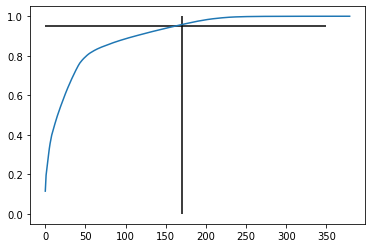

In [18]:
from sklearn.decomposition import PCA

plt.plot(np.cumsum(PCA().fit(x_train).explained_variance_ratio_))
plt.vlines(170,0,1)
plt.hlines(0.95,0,350)
plt.show()

In [19]:
pca_01 = PCA(n_components=170).fit(x_train)
x_train = pca_01.transform(x_train)
x_test = pca_01.transform(x_test)

dump(pca_01, 'pca_01.joblib')

['pca_01.joblib']

## Cost-sensitive Logistic Regression
There is a huge class imbalance (much more on-time than delays), so different costs are assigned to type I/II errors.

In [20]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestRegressor

reg_01 = LogisticRegression().fit(x_train, y_train)
reg_cs = LogisticRegression(class_weight={0:0.25, 1:0.75}, max_iter=1500).fit(x_train, y_train)

y_pred_01 = reg_01.predict(x_test)
y_pred_cs = reg_cs.predict(x_test)

C:\Users\Yang Yan\anaconda3\lib\site-packages\IPython\core\pylabtools.py:132: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


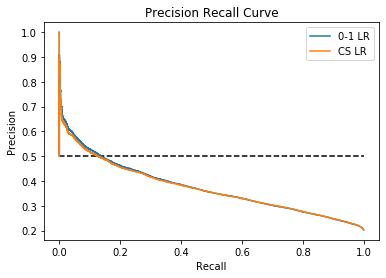

In [21]:
from sklearn.metrics import precision_recall_curve 
y_hat = reg_01.predict_proba(x_test)
p_lg01, r_lg01, _ = precision_recall_curve(y_test, y_hat[:, 1])
y_hat = reg_cs.predict_proba(x_test)
p_lgcs, r_lgcs, _ = precision_recall_curve(y_test, y_hat[:, 1])

plt.plot([0,1], [0.5, 0.5], 'k--')
plt.plot(r_lg01, p_lg01, label='0-1 LR')
plt.plot(r_lgcs, p_lgcs, label='CS LR')
plt.legend()
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision Recall Curve')
plt.show()

In [22]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_test, y_pred_01)

array([[294633,   2757],
       [ 71860,   3845]], dtype=int64)

In [23]:
confusion_matrix(y_test, y_pred_cs)

array([[224114,  73276],
       [ 36405,  39300]], dtype=int64)

In [24]:
reg_01.score(x_test,y_test), reg_cs.score(x_test,y_test)

(0.8000053605650036, 0.7060239349227408)

If we had used a 0-1 loss for logistic regression, the accuracy could have achieved 80%. However, as we are more interested in predicting the late trains, a cost-sensitive regression is introduced to enhance the recall rate of the model. Therefore, the accuracy has dropped to 70% but now it has a recall of about 51.7% (as opposed to 5%). 

## Random Forrest

In [25]:
from sklearn.ensemble import RandomForestClassifier

rfr = RandomForestClassifier(n_estimators=20, class_weight={0:0.25, 1:0.75}, n_jobs=-1, verbose=1).fit(x_train,y_train)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  20 | elapsed:   39.2s remaining:   39.2s
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:  1.1min finished


[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  10 out of  20 | elapsed:    0.2s remaining:    0.2s
[Parallel(n_jobs=16)]: Done  20 out of  20 | elapsed:    0.4s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  10 out of  20 | elapsed:    0.3s remaining:    0.3s
[Parallel(n_jobs=16)]: Done  20 out of  20 | elapsed:    0.4s finished
C:\Users\Yang Yan\anaconda3\lib\site-packages\IPython\core\pylabtools.py:132: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


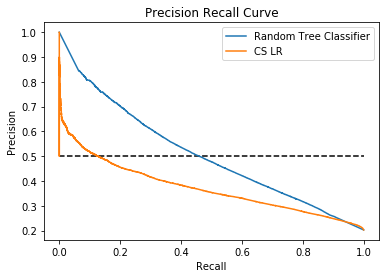

In [26]:
y_pred = rfr.predict(x_test)
y_hat = rfr.predict_proba(x_test)
p_rfr, r_rfr, _ = precision_recall_curve(y_test, y_hat[:, 1])

plt.plot([0,1], [0.5, 0.5], 'k--')
plt.plot(r_rfr, p_rfr, label='Random Tree Classifier')
plt.plot(r_lgcs, p_lgcs, label='CS LR')
plt.legend()
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision Recall Curve')
plt.show()

In [27]:
confusion_matrix(y_test, y_pred)

array([[244852,  52538],
       [ 33590,  42115]], dtype=int64)

In [28]:
# calculate accuracy
sum(y_test == y_pred) / len(y_test)

0.7691526286870636

We could see that the Random Forrest is a better model than Logistic Regression. With the similar level of specificity (true negative rate), the RFR can provide more accuracy (76.8%) and higher recall (55.3%).

## Bayesian Network

In [29]:
from sklearn.naive_bayes import GaussianNB

gnb = GaussianNB().fit(x_train, y_train)
y_pred = gnb.predict(x_test)

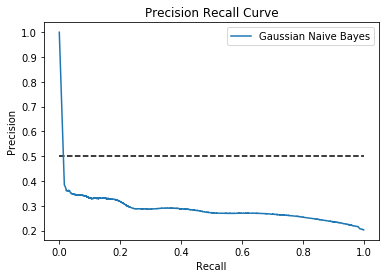

array([[185323, 112067],
       [ 34290,  41415]], dtype=int64)

In [30]:
y_hat = gnb.predict_proba(x_test)
p_gnb, r_gnb, _ = precision_recall_curve(y_test, y_hat[:, 1])
plt.plot([0,1], [0.5, 0.5], 'k--')
plt.plot(r_gnb, p_gnb, label='Gaussian Naive Bayes')
plt.legend()
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision Recall Curve')
plt.show()

confusion_matrix(y_test, y_pred)

This is clearly not a good model and will be discarded.

## Neural Network
Last, Multi-layer Perceptron classifier is used. The first model is an off-shelf model that is not designed for class imbalance.

In [31]:
from sklearn.neural_network import MLPClassifier

clf_01 = MLPClassifier(hidden_layer_sizes=(20,5), random_state=1, max_iter=1500).fit(x_train, y_train)
y_pred = clf_01.predict(x_test)

In [32]:
y_hat = clf_01.predict_proba(x_test)
p_01, r_01, _ = precision_recall_curve(y_test, y_hat[:, 1])
confusion_matrix(y_test, y_pred)

array([[286941,  10449],
       [ 55331,  20374]], dtype=int64)

As we can see, this model does not provide a satisfactory result due to the extreme class imbalance.

## Undersampling using imbalance-learn package
In order to particularly identify train delays, the majority class (on time trains) is undersampled. The majority class is randomly sampled without replacement.

In [33]:
import imblearn
from imblearn.under_sampling import RandomUnderSampler

rus = RandomUnderSampler(random_state=1)
x_res, y_res = rus.fit_resample(x_train, y_train)

In [34]:
clf_res = MLPClassifier(hidden_layer_sizes=(20,5), random_state=1, max_iter=1500).fit(x_res, y_res)
y_pred = clf_res.predict(x_test)

C:\Users\Yang Yan\anaconda3\lib\site-packages\IPython\core\pylabtools.py:132: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


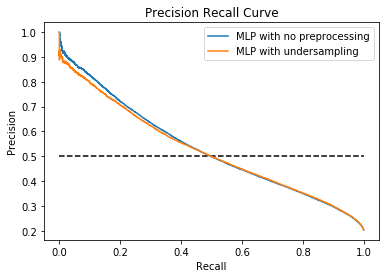

array([[209888,  87502],
       [ 20579,  55126]], dtype=int64)

In [35]:
y_hat = clf_res.predict_proba(x_test)
p_res, r_res, _ = precision_recall_curve(y_test, y_hat[:, 1])
plt.plot([0,1], [0.5, 0.5], 'k--')
plt.plot(r_01, p_01, label='MLP with no preprocessing')
plt.plot(r_res, p_res, label='MLP with undersampling')
plt.legend()
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision Recall Curve')
plt.show()

confusion_matrix(y_test, y_pred)

Undersampling made the model slightly worse if the recall is low and slightly better if the recall is high, which is to be expected. For future model comparisons, only the undersampled model would be used. 

## Balanced Bagging Classifier

In [36]:
from imblearn.ensemble import BalancedBaggingClassifier
bbc = BalancedBaggingClassifier(n_jobs=-1).fit(x_train, y_train)
y_pred = bbc.predict(x_test)

In [37]:
y_hat = bbc.predict_proba(x_test)
p_bbc, r_bbc, _ = precision_recall_curve(y_test, y_hat[:, 1])
confusion_matrix(y_test, y_pred)

array([[216847,  80543],
       [ 23999,  51706]], dtype=int64)

## Comparison of all models

C:\Users\Yang Yan\anaconda3\lib\site-packages\IPython\core\pylabtools.py:132: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


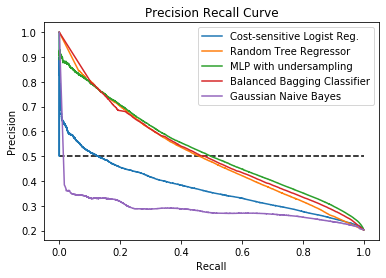

In [38]:
plt.plot([0,1], [0.5, 0.5], 'k--')
plt.plot(r_lgcs, p_lgcs, label='Cost-sensitive Logist Reg.')
plt.plot(r_rfr, p_rfr, label='Random Tree Regressor')
plt.plot(r_res, p_res, label='MLP with undersampling')
plt.plot(r_bbc, p_bbc, label='Balanced Bagging Classifier')
plt.plot(r_gnb, p_gnb, label='Gaussian Naive Bayes')
plt.legend()
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision Recall Curve')
plt.show()

As we can see, when recall > 50%, MLP has the best performance, so it is the model of choice to proceed to the next part.

In [39]:
dump(clf_res, 'MLPClassifier.joblib') 

['MLPClassifier.joblib']

# Prediction of Minutes Delayed

The next step is to predict precisely how many minutes will the train be delayed. In some extreme circumstances, trains are delayed for more than 1 hour, which is likely due to some unforeseen events that is out of scope of this model. Therefore, all delays more than 1 hour is removed from training data. The performance measure is Mean Squared Error.

In [40]:
merged_delay_df = merged_df[(merged_df.delay>6) & (merged_df.delay<60)]

label = merged_delay_df['delay']
features = merged_delay_df.drop(['delay','label'], axis=1)

from sklearn.model_selection import train_test_split
x_train2, x_test2, y_train2, y_test2 = train_test_split(features, label, train_size=0.8)

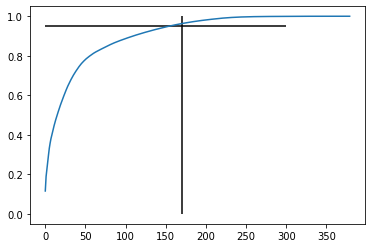

In [41]:
plt.plot(np.cumsum(PCA().fit(x_train2).explained_variance_ratio_))
plt.vlines(170,0,1)
plt.hlines(0.95,0,300)
plt.show()

In [42]:
pca_reg = PCA(n_components=170).fit(x_train2)
x_train2 = pca_reg.transform(x_train2)
x_test2 = pca_reg.transform(x_test2)

dump(pca_reg, 'pca_reg.joblib')

['pca_reg.joblib']

## k-Nearest Neighbor Regression

In [43]:
from sklearn.neighbors import KNeighborsRegressor

knn = KNeighborsRegressor(weights = 'distance', n_jobs=-1).fit(x_train2, y_train2)

In [44]:
err = y_test2 - knn.predict(x_test2)
sum(err**2)/len(err)

71.40401666845858

## Multi-Layer Percepton Regression

In [45]:
from sklearn.neural_network import MLPRegressor

mlp = MLPRegressor(hidden_layer_sizes=(50,10), random_state=1, max_iter=1500).fit(x_train2, y_train2)

In [46]:
err = y_test2 - mlp.predict(x_test2)
sum(err**2)/len(err)

48.55952830259065

It's clear that MLP performs better. Thus, it is the model of choice for prediction of minutes delayed. 

In [47]:
dump(mlp, 'MLPRegressor.joblib') 

['MLPRegressor.joblib']

# User Interface
This UI is designed in a way that it is dependent of all previous sections.

Example output: \
(ON TIME) Nouthbound from 30th South to Bryn Mawr between 7\:00-7:59 on 2020-05-04 \
(DELAY) Southbound from Jefferson Station to University City between 13\:00-13:59 on 2020-05-04.

In [48]:
import pandas as pd
import numpy as np
from ipywidgets import widgets 
from datetime import date
from IPython.display import clear_output
from joblib import dump, load
import requests 
import json
import pickle

api = 'https://api.openweathermap.org/data/2.5/onecall?lat=39.95&lon=-75.16&exclude=current,hourly&appid=cd33dc9264cae75b0d3d1451b0e136fe'
clf_res = load('MLPClassifier.joblib') 
mlp = load('MLPRegressor.joblib') 
pca_01 = load('pca_01.joblib')
pca_reg = load('pca_reg.joblib')
with open("string.txt", "rb") as f:
    column_names, origins, stations = pickle.load(f)

origins_widget = widgets.Dropdown(
    options=origins,
    value=origins[0],
    description='Origin:'
)

direction_widget = widgets.Dropdown(
    options=['N', 'S'],
    value='N',
    description='Direction:'
)

station_widget = widgets.Dropdown(
    options=stations,
    value=stations[0],
    description='Your Station:'
)

date_widget = widgets.DatePicker(
    description='Pick a Date',
    value = date.today(),
    disabled=False
)

time_widget = widgets.Dropdown(
    options=range(24),
    value=12,
    description='Depart Hour:'
)

button = widgets.Button(description="Estimate Arrival")

def on_button_clicked(b):
    clear_output(wait=True)
    user_origin = 'origin_'+origins_widget.value
    user_direc = direction_widget.value
    user_station = 'next_'+station_widget.value
    user_station_date = date_widget.value.weekday() + 1
    user_hour = str(time_widget.value)+'h'
    user_df = pd.DataFrame(columns = column_names)
    user_df = user_df.append(pd.Series(0, index=user_df.columns), ignore_index=True)
    user_df[user_origin] = 1
    user_df[user_direc] = 1
    user_df[user_station] = 1
    user_df[user_station_date] = 1
    user_df[user_hour] = 1
    
    delta_days = (date_widget.value-date.today()).days
    if delta_days < 0:
        print('Error: entered past dates')
    elif delta_days > 7:
        print('Warning: Predicting too far in the future, accuracy is affected.')
        print('')
        user_df['no_rain'] = 1
        user_df['no_snow'] = 1
    else:
        forecast = requests.get(api).content
        forecast_js = json.loads(forecast)
        weather = forecast_js['daily'][delta_days]
        if 'rain' in weather.keys():
            user_df[reformat_rain(weather['rain']/25.4)]=1
            print('It\'s going to rain.')
            print('')
            user_df['no_snow'] = 1
        elif 'snow' in weather.keys():
            user_df['no_rain'] = 1
            print('It\'s going to snow.')
            print('')
            user_df[reformat_snow(weather['snow']/25.4)]=1
        else:
            print('It\'s going to be clear.')
            print('')
            user_df['no_rain'] = 1
            user_df['no_snow'] = 1
          
    if delta_days >= 0:
        print(f'{user_direc}outhbound train from {origins_widget.value} will arrive at {station_widget.value} '+
              f'between {time_widget.value}:00-{time_widget.value}:59 on {date_widget.value}.')

        user_data = pca_01.transform(user_df)
        late = clf_res.predict(user_data)[0]
        if late == 1:
            user_data = pca_reg.transform(user_df)
            delay = mlp.predict(user_data)[0]
            print(f'Estimated Delay: {delay:.2f} minutes.')
        else:
            print('Estimated On Time')
    
    reset_button = widgets.Button(description="Reset")
    reset_button.on_click(start_gui)
    display(reset_button)
        
button.on_click(on_button_clicked)

def start_gui(b):
    clear_output(wait=True)
    display(origins_widget)
    display(direction_widget)
    display(station_widget)
    display(date_widget)
    display(time_widget)
    display(button)

display(origins_widget)
display(direction_widget)
display(station_widget)
display(date_widget)
display(time_widget)
display(button)

It's going to rain.

Nouthbound train from 16th St Jct will arrive at Carpenter between 12:00-12:59 on 2020-05-06.
Estimated On Time


Button(description='Reset', style=ButtonStyle())